In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Importing Basic Libraries

### Basic Pandas and numpy library

In [2]:
import os
import gc
import warnings
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Sklearn Library

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Data Loading

### Main dataset with target variable

In [4]:
visits_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv', parse_dates=["show_date"])

### Online Booking datasets

In [5]:
bnow_theaters_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
bnow_booking_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')

### Cinema Booking Datasets

In [6]:
cpos_theaters_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv')
cpos_booking_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')

### Other datasets

In [7]:
relation_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
calendar_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv', parse_dates=["show_date"])

# Exploring Datasets

### Shape of datasets

In [8]:
print('Shape of Booking Datasets :')
print('booknow visits :', visits_df.shape)
print('booknow theaters :', bnow_theaters_df.shape)
print('booknow booking :', bnow_booking_df.shape)
print('\n')

print('Shape of CinePOS Datasets :')
print('cinePOS booking :', cpos_booking_df.shape)
print('cinePOS theater :', cpos_theaters_df.shape)
print('\n')

print('Shape of Other Datasets :')
print('date info :', calendar_df.shape)
print('movie theater relation :', relation_df.shape)

Shape of Booking Datasets :
booknow visits : (214046, 3)
booknow theaters : (829, 5)
booknow booking : (68336, 4)


Shape of CinePOS Datasets :
cinePOS booking : (1641966, 4)
cinePOS theater : (4690, 5)


Shape of Other Datasets :
date info : (547, 2)
movie theater relation : (150, 2)


### Columns in the datasets

In [9]:
print('Columns of Booking Datasets :')
print('booknow visits :', visits_df.columns.to_list())
print('booknow theaters :', bnow_theaters_df.columns.to_list())
print('booknow booking :', bnow_booking_df.columns.to_list())
print('\n')

print('Columns of CinePOS Datasets :')
print('cinePOS booking :', cpos_booking_df.columns.to_list())
print('cinePOS theater :', cpos_theaters_df.columns.to_list())
print('\n')

print('Columns of Other Datasets :')
print('date info :', calendar_df.columns.to_list())
print('movie theater relation :', relation_df.columns.to_list())

Columns of Booking Datasets :
booknow visits : ['book_theater_id', 'show_date', 'audience_count']
booknow theaters : ['book_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']
booknow booking : ['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked']


Columns of CinePOS Datasets :
cinePOS booking : ['cine_theater_id', 'show_datetime', 'booking_datetime', 'tickets_sold']
cinePOS theater : ['cine_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']


Columns of Other Datasets :
date info : ['show_date', 'day_of_week']
movie theater relation : ['book_theater_id', 'cine_theater_id']


### Datatype Summary

In [10]:
print('Datatypes of Booking Datasets :\n')
print('----booknow visits :---- \n', visits_df.dtypes)
print('----booknow theaters :----\n', bnow_theaters_df.dtypes)
print('----booknow booking :----\n', bnow_booking_df.dtypes)
print('\n')

print('Datatypes of CinePOS Datasets : \n')
print('----cinePOS booking :----\n', cpos_booking_df.dtypes)
print('----cinePOS theater :----\n', cpos_theaters_df.dtypes)
print('\n')

print('Datatypes of Other Datasets :\n')
print('----date info :----\n', calendar_df.dtypes)
print('----movie theater relation :----\n', relation_df.dtypes)

Datatypes of Booking Datasets :

----booknow visits :---- 
 book_theater_id            object
show_date          datetime64[ns]
audience_count              int64
dtype: object
----booknow theaters :----
 book_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object
----booknow booking :----
 book_theater_id     object
show_datetime       object
booking_datetime    object
tickets_booked       int64
dtype: object


Datatypes of CinePOS Datasets : 

----cinePOS booking :----
 cine_theater_id     object
show_datetime       object
booking_datetime    object
tickets_sold         int64
dtype: object
----cinePOS theater :----
 cine_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object


Datatypes of Other Datasets :

----date info :----
 show_date      datetime64[ns]
day_of_week            object
dtype: object
----movie

### Sample Records

In [11]:
print('----Booknow Visits---- \n')
display(visits_df.head(3))

print('----Booknow Theaters----\n')
display(bnow_theaters_df.head(3))

print('----Booknow Booking----\n')
display(bnow_booking_df.head(3))

print('----CinePOS Booking----\n')
display(cpos_booking_df.head(3))

print('----cinePOS theater----\n')
display(cpos_theaters_df.head(3))

print('----Date info----\n')
display(calendar_df.head(3))

print('----Movie theater relation----\n')
display(relation_df.head(3))

----Booknow Visits---- 



,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58


----Booknow Theaters----



,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017


----Booknow Booking----



,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6


----CinePOS Booking----



,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2


----cinePOS theater----



,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017


----Date info----



,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday


----Movie theater relation----



,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923


### Checking for null values

In [12]:
visits_df.isna().sum()

book_theater_id    0
show_date          0
audience_count     0
dtype: int64

In [13]:
calendar_df.isna().sum()

show_date      0
day_of_week    0
dtype: int64

### Visualizations

In [14]:
datasets = {
    "BookNow Visits": visits_df,
    "BookNow Theaters": bnow_theaters_df,
    "BookNow Booking": bnow_booking_df,
    "CinePOS Booking": cpos_booking_df,
    "CinePOS Theater": cpos_theaters_df,
    "Calendar Info": calendar_df,
    "Movie-Theater Relation": relation_df
}

dataset_summary = pd.DataFrame({
    "Dataset": datasets.keys(),
    "Rows": [len(df) for df in datasets.values()],
    "Columns": [df.shape[1] for df in datasets.values()]
})

display(dataset_summary)


,Dataset,Rows,Columns
0,BookNow Visits,214046,3
1,BookNow Theaters,829,5
2,BookNow Booking,68336,4
3,CinePOS Booking,1641966,4
4,CinePOS Theater,4690,5
5,Calendar Info,547,2
6,Movie-Theater Relation,150,2


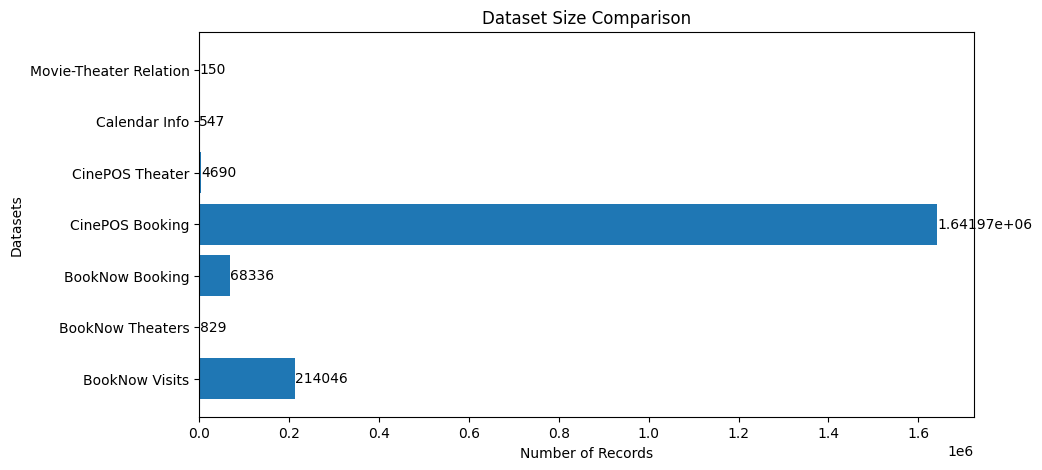

In [15]:
plt.figure(figsize=(10, 5))

bars = plt.barh(dataset_summary["Dataset"], dataset_summary["Rows"])

plt.title("Dataset Size Comparison")
plt.xlabel("Number of Records")
plt.ylabel("Datasets")

plt.bar_label(bars)

plt.show()


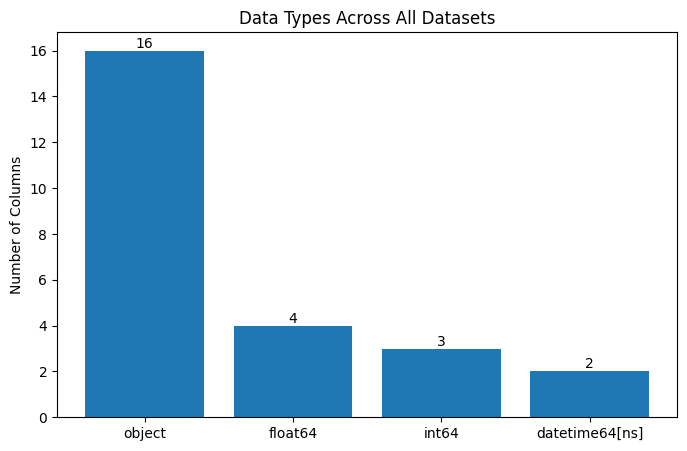

In [16]:
# Combine dtype counts from all datasets in one line
dtype_counts = pd.Series([
    str(dtype) for df in datasets.values() for dtype in df.dtypes
]).value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(dtype_counts.index, dtype_counts.values)

plt.title("Data Types Across All Datasets")
plt.ylabel("Number of Columns")
plt.bar_label(bars)

plt.show()


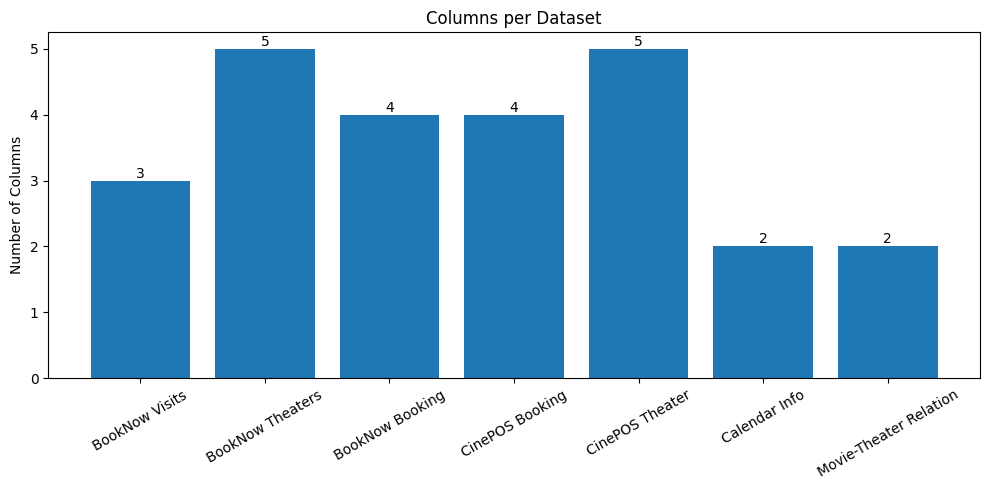

In [17]:
plt.figure(figsize=(10, 5))

bars = plt.bar(dataset_summary["Dataset"], dataset_summary["Columns"])

plt.title("Columns per Dataset")
plt.ylabel("Number of Columns")
plt.xticks(rotation=30)

plt.bar_label(bars)

plt.tight_layout()
plt.show()


# Merging Datasets

Merging visits dataset (with target variable) with the calendar info 

In [18]:
visits_df = visits_df.merge(calendar_df, on="show_date", how="left")

Creating features using date column like month, day of week, weekend flag (boolean for weekends), holiday flag

In [19]:
visits_df["day_of_week"] = visits_df["show_date"].dt.dayofweek
visits_df["month_num"] = visits_df["show_date"].dt.month
visits_df["weekend_flag"] = visits_df["day_of_week"].isin([5, 6]).astype(int)
visits_df["holiday_flag"] = (visits_df.get("holiday_flg", pd.Series(0, index=visits_df.index)) == 1).astype(int)

In [20]:
visits_df = visits_df.sort_values(["book_theater_id", "show_date"])
theater_groups = visits_df.groupby("book_theater_id")["audience_count"]

# Feature Engineering 

### Lag features

In [21]:
visits_df["audience_lag1"] = theater_groups.shift(1)
visits_df["audience_lag7"] = theater_groups.shift(7)
visits_df["audience_lag14"] = theater_groups.shift(14)

### Rolling features

In [22]:
visits_df["rolling_mean_7d"] = theater_groups.rolling(7, min_periods=1).mean().shift(1).values
visits_df["rolling_mean_14d"] = theater_groups.rolling(14, min_periods=1).mean().shift(1).values
visits_df["rolling_mean_30d"] = theater_groups.rolling(30, min_periods=1).mean().shift(1).values

In [23]:
# Exponential moving average
visits_df["ema_7d"] = theater_groups.apply(lambda x: x.ewm(span=7, min_periods=1).mean().shift(1)).reset_index(level=0, drop=True)

# Difference features
visits_df["diff_1d"] = visits_df["audience_count"] - visits_df["audience_lag1"]
visits_df["diff_7d"] = visits_df["audience_count"] - visits_df["audience_lag7"]

print('Feature Engineering Done')

Feature Engineering Done


# Final Dataset merging

In [24]:
bnow_booking_df["show_date"] = pd.to_datetime(bnow_booking_df["show_datetime"]).dt.date
bnow_booking_df["show_date"] = pd.to_datetime(bnow_booking_df["show_date"])

In [25]:
bookings_agg = bnow_booking_df.groupby(["book_theater_id", "show_date"])["tickets_booked"].sum().reset_index()
visits_df = visits_df.merge(bookings_agg, on=["book_theater_id", "show_date"], how="left")
visits_df["tickets_booked"].fillna(0, inplace=True)

/tmp/ipykernel_13/1674167659.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  visits_df["tickets_booked"].fillna(0, inplace=True)


In [26]:
theater_dow_avg = visits_df.groupby(["book_theater_id", "day_of_week"])["audience_count"].mean()
theater_avg = visits_df.groupby("book_theater_id")["audience_count"].mean()
overall_avg = visits_df["audience_count"].mean()

### Theater Encoding features

In [27]:
visits_df["theater_baseline"] = visits_df["book_theater_id"].map(theater_avg)
visits_df["theater_dow_baseline"] = visits_df.apply(
    lambda x: theater_dow_avg.get((x["book_theater_id"], x["day_of_week"]), overall_avg), axis=1
)

### Theater frequency encoding (how often each theater appears)

In [28]:
theater_freq = visits_df["book_theater_id"].value_counts()
visits_df["theater_frequency"] = visits_df["book_theater_id"].map(theater_freq)

print('Final Dataset features done')

Final Dataset features done


# Identifying and handling nulls

In [29]:
visits_df.isna().sum()

book_theater_id             0
show_date                   0
audience_count              0
day_of_week                 0
month_num                   0
weekend_flag                0
holiday_flag                0
audience_lag1             826
audience_lag7            5771
audience_lag14          11539
rolling_mean_7d             1
rolling_mean_14d            1
rolling_mean_30d            1
ema_7d                    826
diff_1d                   826
diff_7d                  5771
tickets_booked              0
theater_baseline            0
theater_dow_baseline        0
theater_frequency           0
dtype: int64

In [30]:
impute_columns = ["audience_lag1", "audience_lag7", "audience_lag14", 
                  "rolling_mean_7d", "rolling_mean_14d", "rolling_mean_30d",
                  "ema_7d", "diff_1d", "diff_7d"]

#### Using Simple Imputer to handle the null values

In [31]:
median_imputer = SimpleImputer(strategy='median')

In [32]:
train_data = visits_df.dropna(subset=["audience_lag1", "rolling_mean_7d", "rolling_mean_14d", 
                                       "audience_lag7", "audience_lag14"]).copy()

train_data[impute_columns] = median_imputer.fit_transform(train_data[impute_columns])
print(f"Training records: {len(train_data)}")

Training records: 202507


# EDA on the final dataset

### Basic Data Structure

In [33]:
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   book_theater_id       214046 non-null  object        
 1   show_date             214046 non-null  datetime64[ns]
 2   audience_count        214046 non-null  int64         
 3   day_of_week           214046 non-null  int32         
 4   month_num             214046 non-null  int32         
 5   weekend_flag          214046 non-null  int64         
 6   holiday_flag          214046 non-null  int64         
 7   audience_lag1         213220 non-null  float64       
 8   audience_lag7         208275 non-null  float64       
 9   audience_lag14        202507 non-null  float64       
 10  rolling_mean_7d       214045 non-null  float64       
 11  rolling_mean_14d      214045 non-null  float64       
 12  rolling_mean_30d      214045 non-null  float64       
 13 

In [34]:
visits_df.describe(include='number')

,audience_count,day_of_week,month_num,weekend_flag,holiday_flag,audience_lag1,audience_lag7,audience_lag14,rolling_mean_7d,rolling_mean_14d,rolling_mean_30d,ema_7d,diff_1d,diff_7d,tickets_booked,theater_baseline,theater_dow_baseline,theater_frequency
count,214046.000000,214046.000000,214046.000000,214046.000000,214046.0,213220.000000,208275.000000,202507.000000,214045.000000,214045.000000,214045.000000,213220.000000,213220.000000,208275.000000,214046.000000,214046.000000,214046.000000,214046.000000
mean,41.616568,3.162652,6.705012,0.312802,0.0,41.634959,41.616229,41.634452,41.640828,41.649376,41.704760,41.642608,-0.031808,0.008326,1.344347,41.616568,41.616568,290.115134
std,32.834918,1.976210,3.778203,0.463636,0.0,32.814951,32.825025,32.848217,23.842554,23.101733,22.610903,23.989644,32.436090,31.599189,7.112112,21.008027,24.325846,87.342061
min,2.000000,0.000000,1.000000,0.000000,0.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,-1304.000000,-1254.000000,0.000000,2.411348,2.000000,1.000000
25%,18.000000,1.000000,2.000000,0.000000,0.0,18.000000,18.000000,18.000000,22.857143,23.142857,23.466667,22.742843,-14.000000,-14.000000,0.000000,23.989848,22.440678,212.000000
50%,34.000000,3.000000,7.000000,0.000000,0.0,34.000000,34.000000,34.000000,37.142857,37.285714,37.533333,36.958272,0.000000,0.000000,0.000000,38.400000,36.687500,283.000000
75%,58.000000,5.000000,10.000000,1.000000,0.0,58.000000,58.000000,58.000000,56.571429,56.571429,56.800000,56.459717,14.000000,14.000000,0.000000,56.635484,55.714286,370.000000
max,1350.000000,6.000000,12.000000,1.000000,0.0,1350.000000,1350.000000,1350.000000,335.142857,264.000000,264.000000,417.419459,1334.000000,1272.000000,1633.000000,127.543147,240.235294,424.000000


In [35]:
print('Dataset shape: ',visits_df.shape[0],'rows × ', visits_df.shape[1] ,'columns')
print('Date range: ', visits_df['show_date'].min().date(), 'to' , visits_df['show_date'].max().date())
print('Unique theaters: ', visits_df['book_theater_id'].nunique())
print('Time span: ' , (visits_df['show_date'].max() - visits_df['show_date'].min()).days, 'days')

Dataset shape:  214046 rows ×  20 columns
Date range:  2023-01-01 to 2024-02-28
Unique theaters:  826
Time span:  423 days


### Columns present

In [36]:
print(visits_df.columns.to_list())

['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'month_num', 'weekend_flag', 'holiday_flag', 'audience_lag1', 'audience_lag7', 'audience_lag14', 'rolling_mean_7d', 'rolling_mean_14d', 'rolling_mean_30d', 'ema_7d', 'diff_1d', 'diff_7d', 'tickets_booked', 'theater_baseline', 'theater_dow_baseline', 'theater_frequency']


### Target Variable Statistics

In [37]:
audience = visits_df['audience_count']
print('Basic statistics :')
print('Mean: ', round(audience.mean(), 2))
print('Median :' , round(audience.median(), 2))
print('Min: ', audience.min())
print('Max: ', audience.max())
print('Standard deviation: ', round(audience.std(), 2))

Basic statistics :
Mean:  41.62
Median : 34.0
Min:  2
Max:  1350
Standard deviation:  32.83


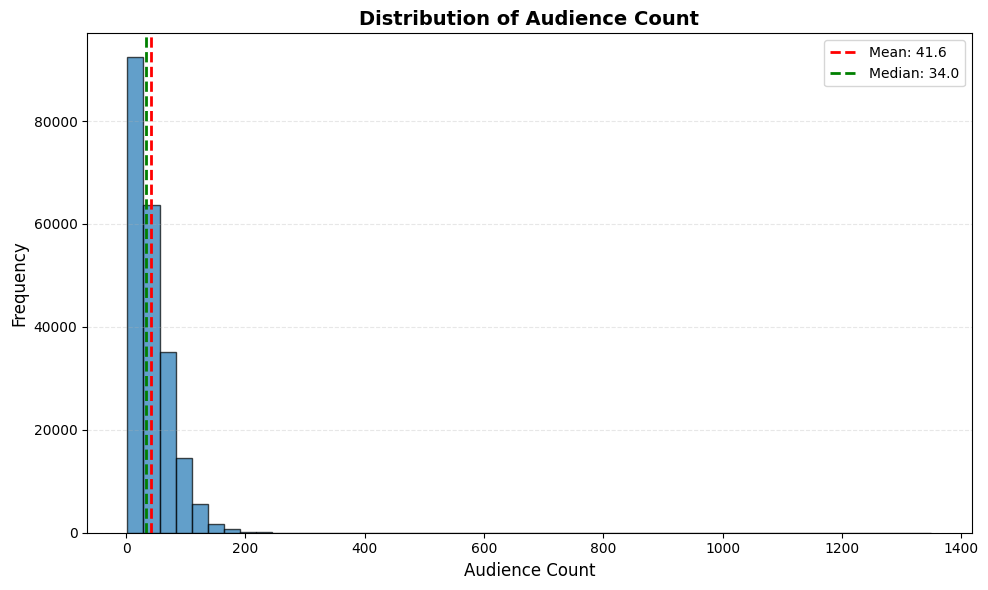

In [38]:
plt.figure(figsize=(10, 6))

plt.hist(audience, bins=50, alpha=0.7, edgecolor='black')

plt.axvline(audience.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {audience.mean():.1f}')

plt.axvline(audience.median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: {audience.median():.1f}')

plt.title('Distribution of Audience Count', fontsize=14, fontweight='bold')
plt.xlabel('Audience Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.legend()

plt.tight_layout()
plt.show()

### Audience pattern

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


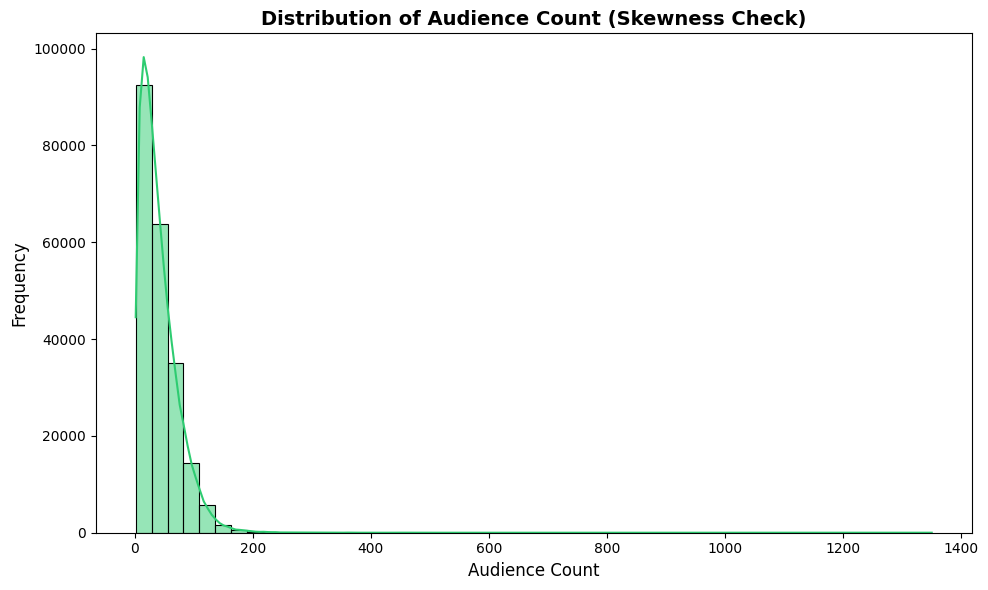

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(visits_df['audience_count'], bins=50, kde=True, color='#2ecc71',edgecolor='black', linewidth=0.8)
plt.title('Distribution of Audience Count (Skewness Check)', fontsize=14, fontweight='bold')
plt.xlabel('Audience Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

- The vast majority of the data points are clustered very close to zero (low audience counts). The tail of the distribution extends far to the right, towards higher audience counts
- The graph shows that the data is right skewed because the long tail of the distribution extends to the right side
- In order to deal with this kind of data feature scaling can be done in order to make the data normally distributed

### Weekend vs Weekday

In [40]:
weekend_audience = visits_df[visits_df['weekend_flag'] == 1]['audience_count'].mean()
weekday_audience = visits_df[visits_df['weekend_flag'] == 0]['audience_count'].mean()

print('Average Weekend Audience is ', weekend_audience)
print('Average Weekday Audience is ', weekday_audience)

Average Weekend Audience is  48.440660752158195
Average Weekday Audience is  38.51034726565687


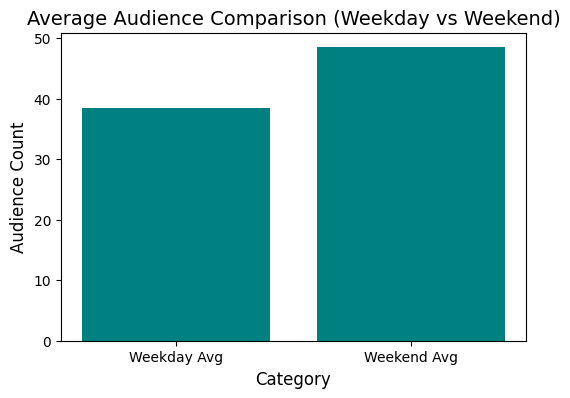

In [41]:
labels = ['Weekday Avg', 'Weekend Avg']
values = [weekday_audience, weekend_audience]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color='teal')
plt.title('Average Audience Comparison (Weekday vs Weekend)', fontsize=14)
plt.ylabel('Audience Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

- The weekend audience is significantly higher than the weekday audience.

- This indicates a strong positive weekend effect, meaning more people tend to visit  cinemas during weekends compared to weekdays.

### Monthly Patterns

In [42]:
monthly_average = visits_df.groupby('month_num')['audience_count'].mean()

print("Average audience by month:")
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month, avg in monthly_average.items():
    print(f"  {month_names[month]:3s}: {avg:6.2f}")

Average audience by month:
  Jan:  39.95
  Feb:  40.96
  Mar:  45.73
  Apr:  45.07
  May:  44.02
  Jun:  42.64
  Jul:  42.54
  Aug:  39.50
  Sep:  39.82
  Oct:  40.64
  Nov:  39.50
  Dec:  46.26


In [43]:
highest_month_avg = monthly_average.idxmax()
lowest_month_avg = monthly_average.idxmin()
seasonal_variation = ((monthly_average.max() - monthly_average.min()) / monthly_average.mean()) * 100

print('Month with Highest average Audience is ', highest_month_avg)
print('Month with Lowest average Audience is ', lowest_month_avg)
print('Seasonal Variation ', seasonal_variation)

Month with Highest average Audience is  12
Month with Lowest average Audience is  8
Seasonal Variation  16.01377941634973


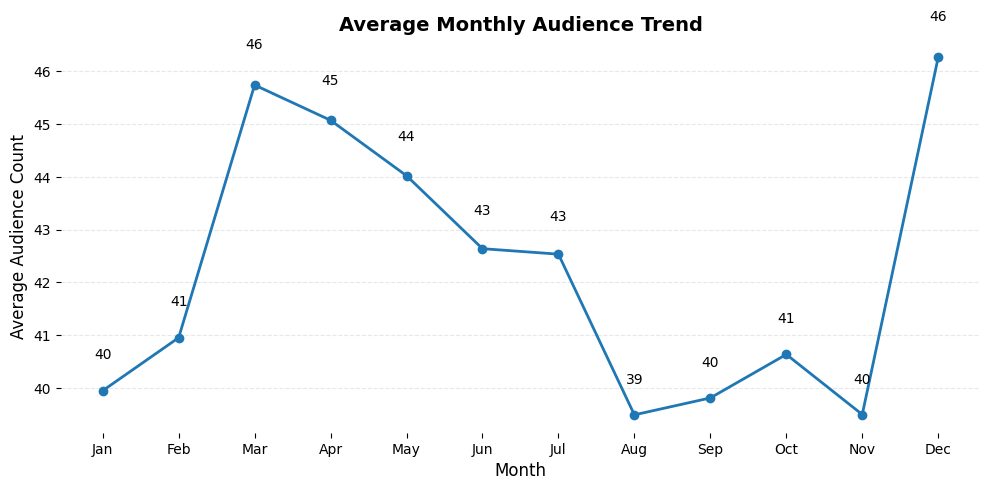

In [44]:
months = [month_names[m] for m in monthly_average.index]
values = monthly_average.values

plt.figure(figsize=(10, 5))

plt.plot(months, values, marker='o', linewidth=2)

for i, val in enumerate(values):
    plt.text(i, val + (val * 0.015), f"{val:.0f}", ha='center', fontsize=10)

plt.title("Average Monthly Audience Trend", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Audience Count", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.box(False)

plt.tight_layout()
plt.show()

- Jan–Mar:
  - Audience numbers start low and gradually increase. This suggests a slow start to the year likely due to holidays ending, people returning to work/school, and fewer major releases.

- Apr–Aug (Peak Season):
  - There is a sharp rise from April onward, with audience counts reaching their highest in June and July.
  - This likely indicates:

    - School/college vacations

    - Major blockbuster releases

    - Festivals or long weekends

    - Summer holiday entertainment demand

  - The peak in July suggests this is the strongest cinema season.

- Sep–Dec (Decline Phase):
  - After August, the audience size starts dropping steadily through September–October and continues to decline into November and December.
This may be due to:

  - Festival spending shifts (shopping, travel, Diwali, Christmas)

  - Fewer major movie releases

  - Weather or exam periods affecting attendance

### Trend Patterns

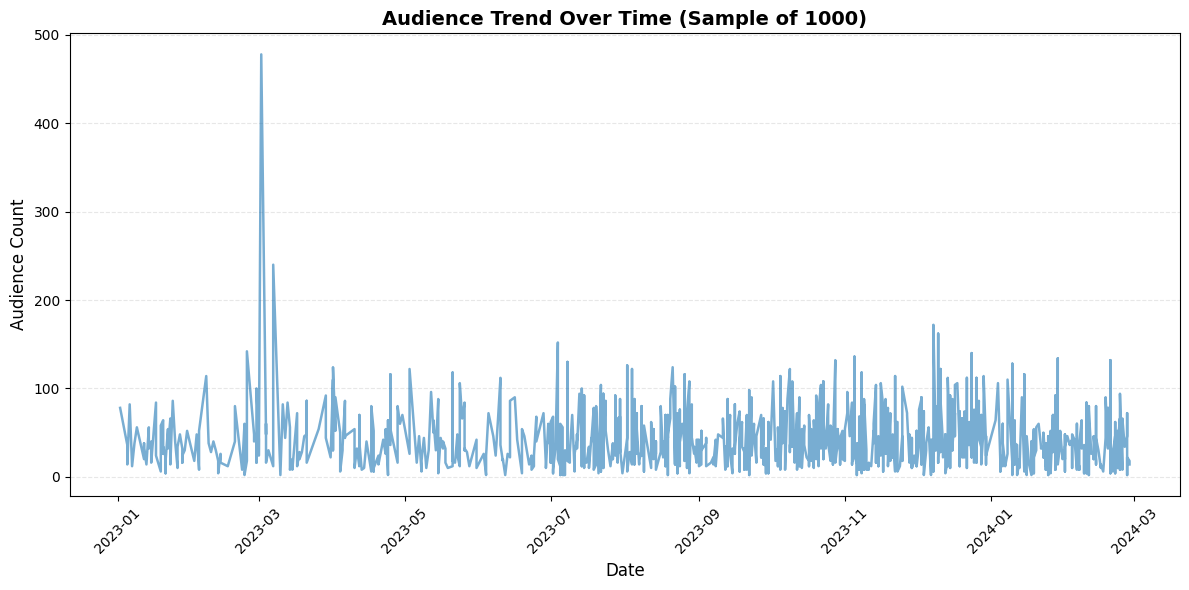

In [45]:
plt.figure(figsize=(12, 6))

if len(visits_df) > 1000:
    plot_df = visits_df.sample(n=1000, random_state=42).sort_values('show_date')
    title_text = "Audience Trend Over Time (Sample of 1000)"
else:
    plot_df = visits_df.sort_values('show_date')
    title_text = "Audience Trend Over Time"

plt.plot(plot_df['show_date'], plot_df['audience_count'], alpha=0.6, linewidth=1.8)

plt.title(title_text, fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Audience Count', fontsize=12)

plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

- The time-series plot shows how cinema audience count changes chronologically across the dataset. By visualizing the attendance over time, we can observe overall movement, patterns, and fluctuations rather than just isolated statistics.

### Top Theater Variability

Text(0, 0.5, 'Audience Count')

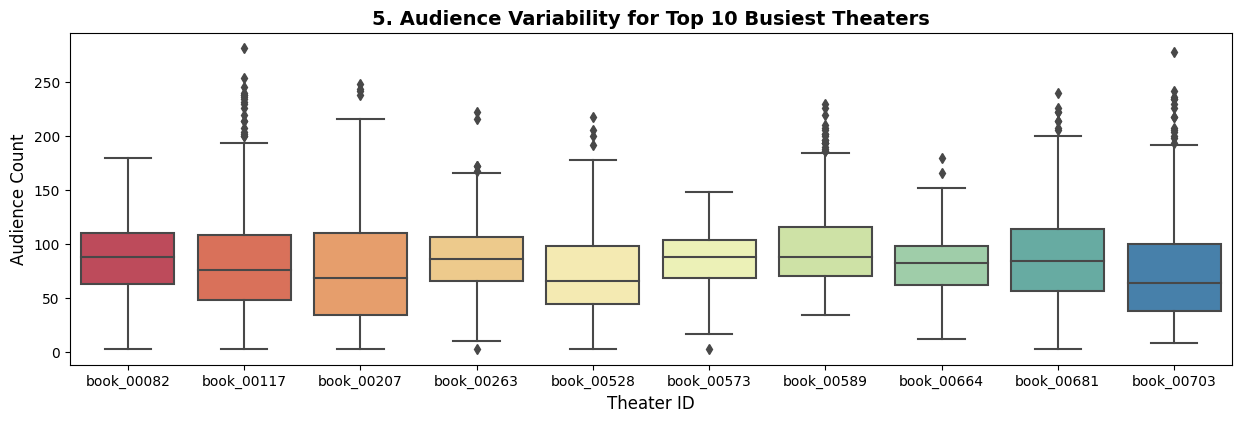

In [46]:
fig = plt.figure(figsize=(15, 25))
ax5 = fig.add_subplot(5, 1, 4)
# Identify top 10 theaters by total audience count for visualization
top_theaters = visits_df.groupby('book_theater_id')['audience_count'].sum().nlargest(10).index
visits_top = visits_df[visits_df['book_theater_id'].isin(top_theaters)]
sns.boxplot(x='book_theater_id', y='audience_count', data=visits_top, ax=ax5, palette='Spectral')
ax5.set_title('5. Audience Variability for Top 10 Busiest Theaters', fontsize=14, fontweight='bold')
ax5.set_xlabel('Theater ID', fontsize=12)
ax5.set_ylabel('Audience Count', fontsize=12)

### Total audience count by top theater ids

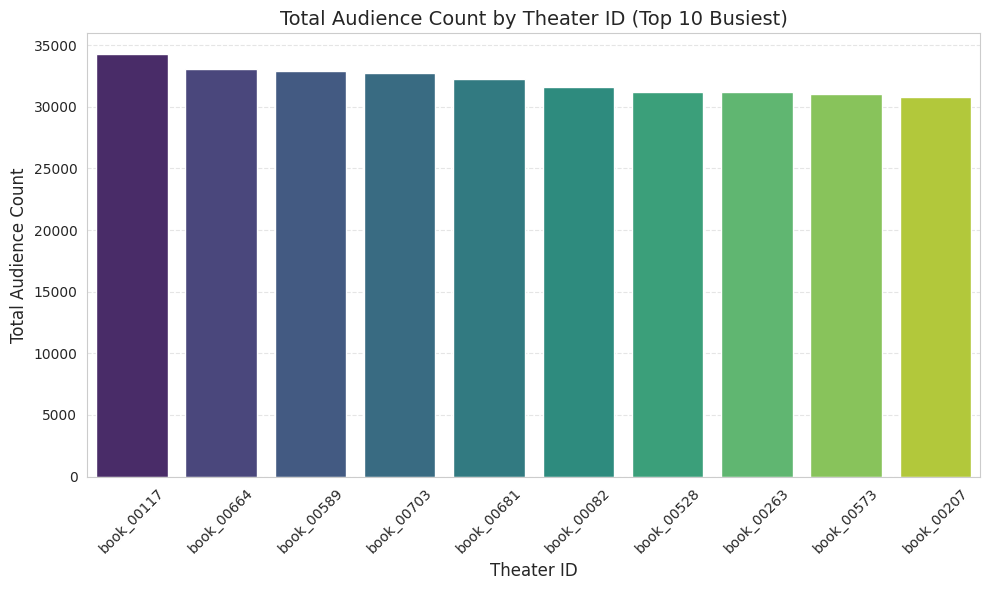

In [47]:
top_theaters_sum = visits_df.groupby('book_theater_id')['audience_count'].sum().nlargest(10).reset_index()
top_theaters_sum['book_theater_id'] = top_theaters_sum['book_theater_id'].astype(str)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    x='book_theater_id', 
    y='audience_count', 
    data=top_theaters_sum, 
    palette='viridis',
    order=top_theaters_sum.sort_values(by='audience_count', ascending=False)['book_theater_id']
)

plt.title('Total Audience Count by Theater ID (Top 10 Busiest)', fontsize=14)
plt.xlabel('Theater ID', fontsize=12)
plt.ylabel('Total Audience Count', fontsize=12)
plt.xticks(rotation=45) 

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- book_00117 is the busiest theater with the highest total audience count, around 34,000+.

- The next few theaters book_00664, book_00589, book_00703, book_00681 all have very similar totals (around 32,000–33,000).

- Toward the end, book_00573 and book_00207 have slightly lower values (~31,000), but still rank among the top 10.

- Overall, all top 10 theaters are very close in total audience count — the difference between rank 1 and rank 10 is only about 3,000–4,000, meaning all of them are consistently high-performing theaters.

### Audience vs Ticket booked

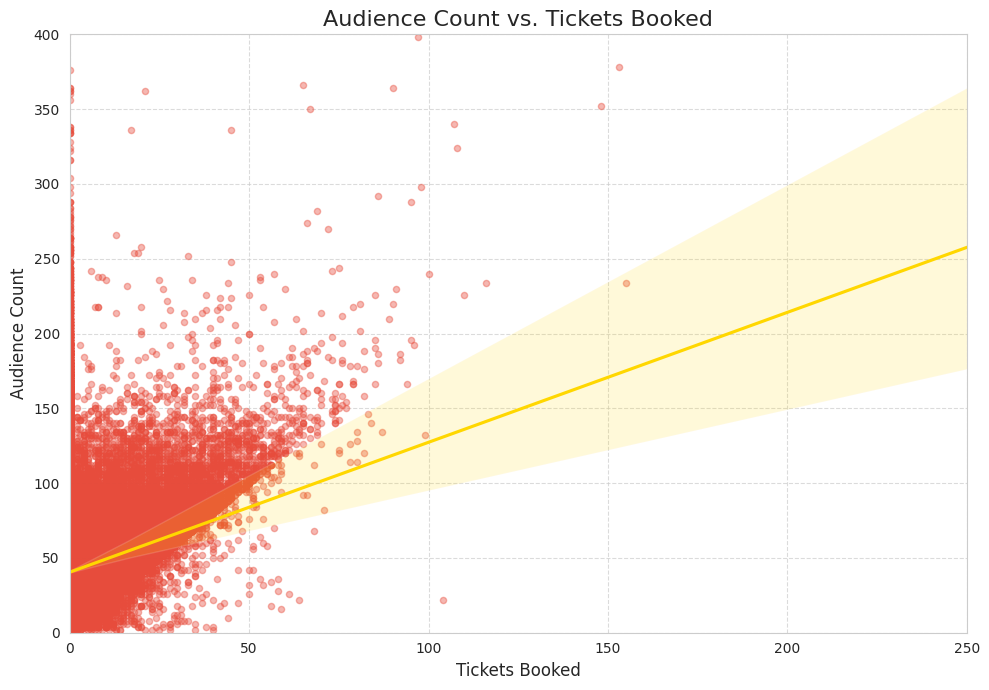

In [48]:
plt.figure(figsize=(10, 7))
sns.regplot(x='tickets_booked', y='audience_count', data=visits_df, 
            scatter_kws={'alpha':0.4, 'color':'#e74c3c', 's':20}, 
            line_kws={'color':'gold'},       
            ax=plt.gca())

plt.xlim(0, 250)
plt.ylim(0, 400) 

plt.title('Audience Count vs. Tickets Booked', fontsize=16)
plt.xlabel('Tickets Booked', fontsize=12)
plt.ylabel('Audience Count', fontsize=12)

plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

- Strong Positive Correlation
- The clear upward slope of the green line visually confirms the strongest relationship in the data
- As the number of tickets booked increases, the final audience count increases proportionally

### Correlation between features

In [49]:
numeric_cols = visits_df.select_dtypes(include=[np.number]).columns
corr_matrix = visits_df[numeric_cols].corr()

#### Correlation of audience with other features

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


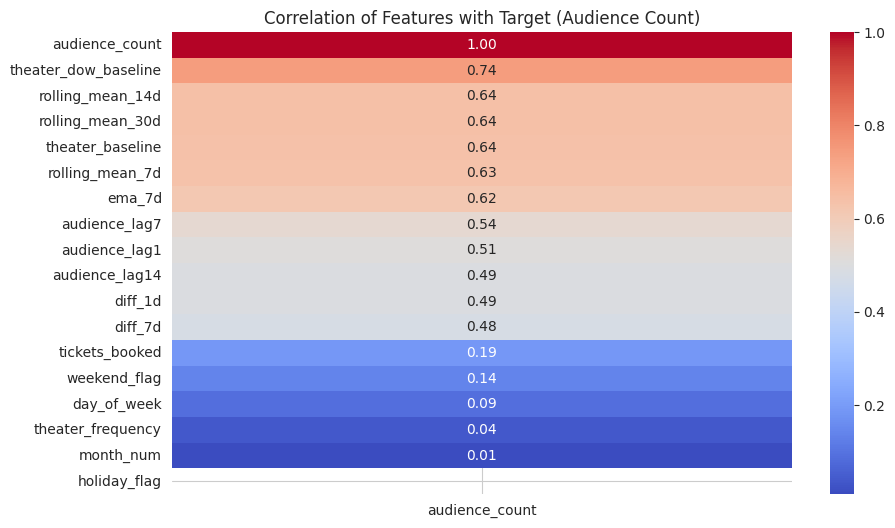

In [50]:
target_corr = corr_matrix['audience_count'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation of Features with Target (Audience Count)")
plt.show()

- The average attendance for a specific theater on a specific day of the week is the  most important factor.

- The recent average audience count (over 7, 14, or 30 days) is highly correlated with the current audience count. This captures the long-term popularity and trend, and validates including these trend-capturing features.



#### Correlation between all the features

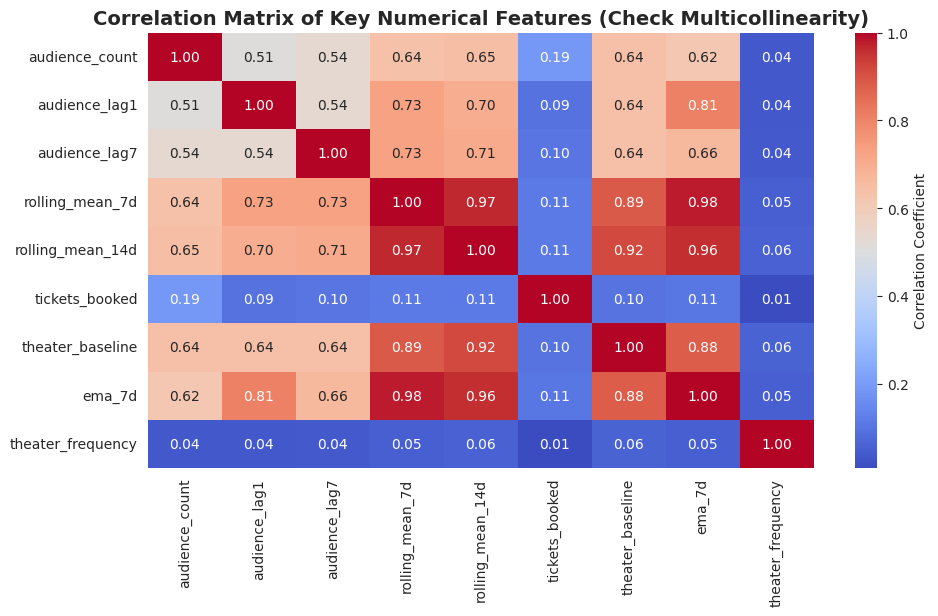

In [51]:
fig = plt.figure(figsize=(10, 25))
ax8 = fig.add_subplot(5, 1, 5)
corr_features = [
    "audience_count", "audience_lag1", "audience_lag7", "rolling_mean_7d",
    "rolling_mean_14d", "tickets_booked", "theater_baseline", "ema_7d", "theater_frequency"
]
# Drop NaNs temporarily for correlation calculation, as correlation requires non-null pairs
corr_matrix = visits_df[corr_features].dropna().corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax8, 
            cbar_kws={'label': 'Correlation Coefficient'})
ax8.set_title('Correlation Matrix of Key Numerical Features (Check Multicollinearity)', fontsize=14, fontweight='bold')

plt.tight_layout()

- Correlation is a statistical measure that quantifies the linear relationship between two variables.
- It is represented by the Pearson correlation coefficient ($r$)
- It ranges from $\mathbf{-1.0}$ to $\mathbf{+1.0}$.

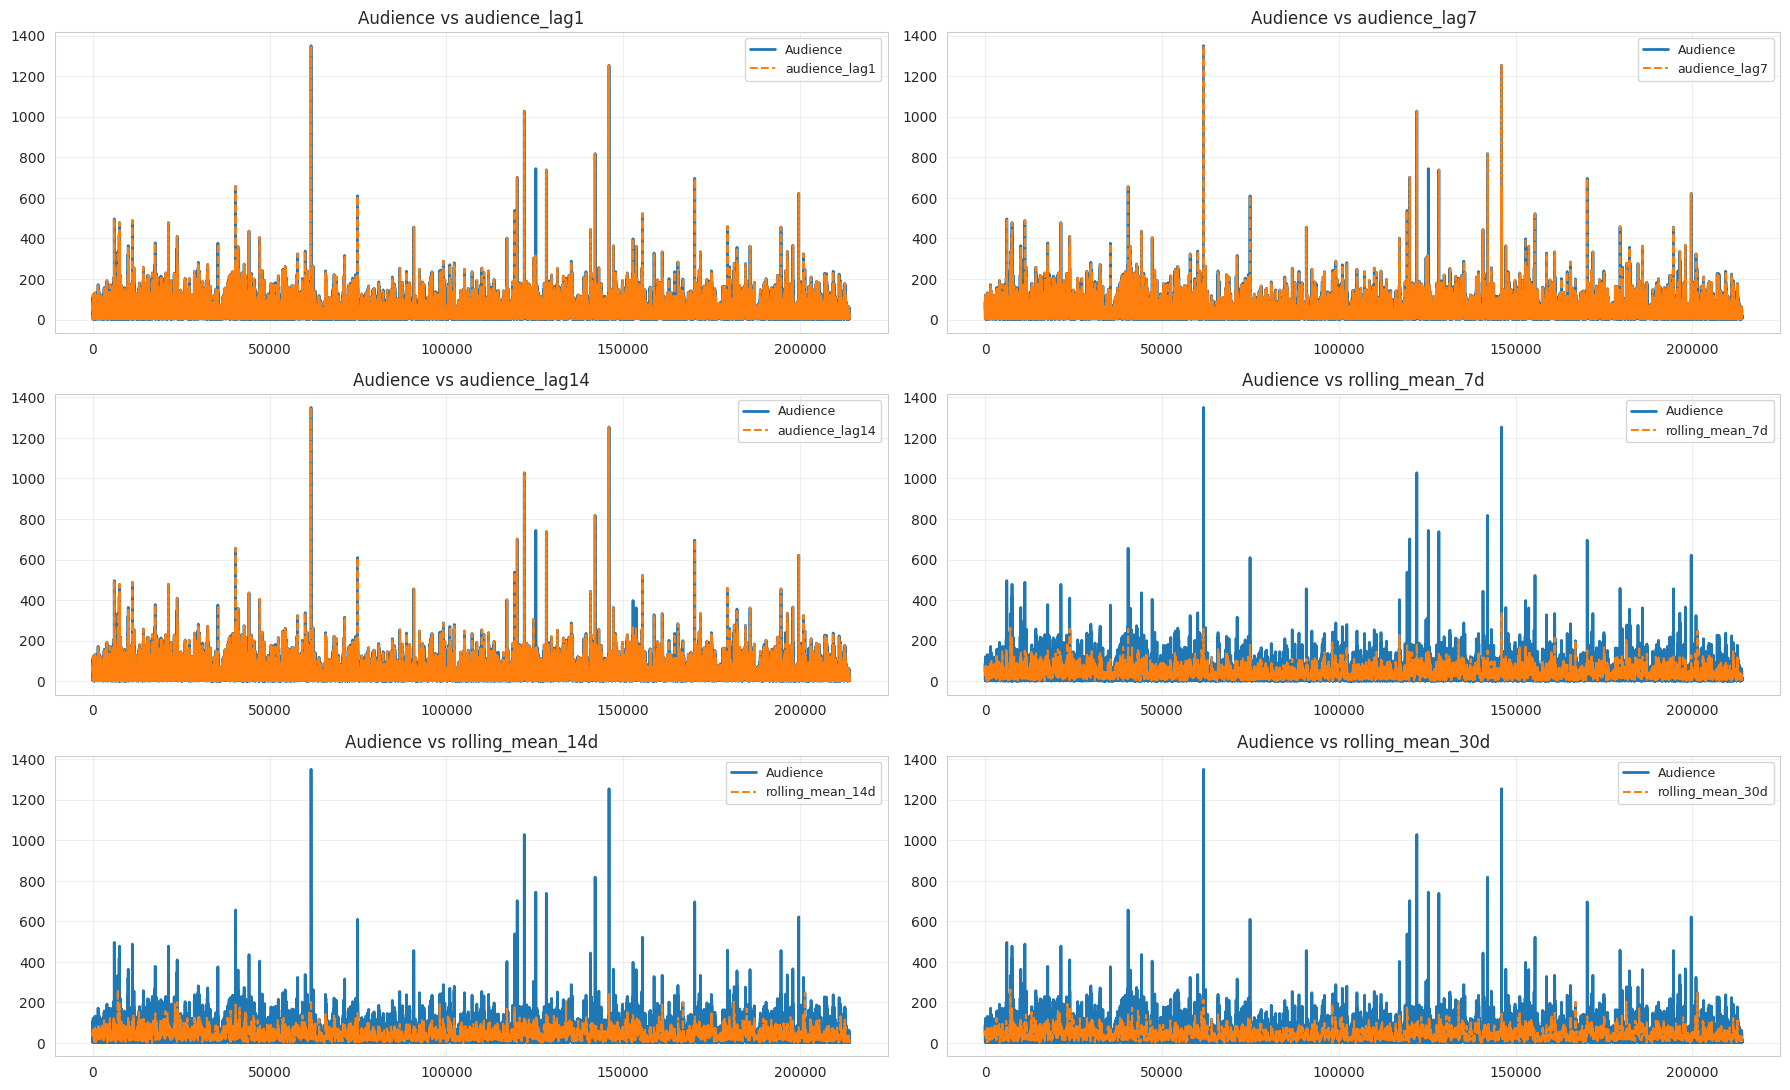

In [52]:
feature_cols = [
    "audience_lag1", "audience_lag7", "audience_lag14",
    "rolling_mean_7d", "rolling_mean_14d", "rolling_mean_30d",
]

plt.figure(figsize=(18, 18))
rows = 5
cols = 2

for i, col in enumerate(feature_cols, start=1):
    plt.subplot(rows, cols, i)
    plt.plot(visits_df.index, visits_df["audience_count"], label="Audience", linewidth=2)
    plt.plot(visits_df.index, visits_df[col], label=col, linestyle='--')
    plt.title(f"Audience vs {col}")
    plt.grid(alpha=0.3)
    plt.legend(fontsize=9)

plt.tight_layout()
plt.show()


- This visualization displays the relationship between the Audience Count (the target variable) and various Lagging and Rolling Mean features.

# Baseline model

In [53]:
BASELINE_COEFF = 0.68
ROLLING_7D_COEFF = 0.06
ROLLING_14D_COEFF = 0.05
LAG1_COEFF = 0.08
LAG7_COEFF = 0.02
LAG14_COEFF = 0.05
TICKETS_COEFF = 0.32
EMA_COEFF = 0.01
DIFF_COEFF = 0.03
HOLIDAY_MULTIPLIER = 0.04
WEEKEND_MULTIPLIER = 0.05

In [54]:
def generate_rule_based_forecast(data_row):
  
    theater_id = data_row["book_theater_id"]
    day_week = data_row["day_of_week"]
    
    # Get baseline value
    base_value = theater_dow_avg.get((theater_id, day_week), 
                                      theater_avg.get(theater_id, overall_avg))
    
    forecast = (
        BASELINE_COEFF * base_value +
        ROLLING_7D_COEFF * data_row["rolling_mean_7d"] +
        ROLLING_14D_COEFF * data_row["rolling_mean_14d"] +
        LAG1_COEFF * data_row["audience_lag1"] +
        LAG7_COEFF * data_row["audience_lag7"] +
        LAG14_COEFF * data_row["audience_lag14"] +
        TICKETS_COEFF * data_row["tickets_booked"] +
        EMA_COEFF * data_row["ema_7d"] +
        DIFF_COEFF * (data_row["diff_1d"] + data_row["diff_7d"]) / 2 +
        HOLIDAY_MULTIPLIER * data_row["holiday_flag"] * base_value +
        WEEKEND_MULTIPLIER * data_row["weekend_flag"] * data_row["rolling_mean_7d"]
    )
    return forecast

In [55]:
train_data["rule_based_forecast"] = train_data.apply(generate_rule_based_forecast, axis=1)
train_data["smoothed_rule_forecast"] = train_data["rule_based_forecast"].rolling(3, min_periods=1).mean()

# Scaling and Encoding features

In [56]:
ml_features = [
    "day_of_week", "month_num", "weekend_flag", "holiday_flag",
    "audience_lag1", "audience_lag7", "rolling_mean_7d", "rolling_mean_14d",
    "tickets_booked", "theater_baseline", "ema_7d", "theater_frequency"
]

In [57]:
X_train_full = train_data[ml_features].copy()
y_train_full = train_data["audience_count"].copy()

In [58]:
numerical_features = ["audience_lag1", "audience_lag7", "rolling_mean_7d", "rolling_mean_14d",
                      "tickets_booked", "theater_baseline", "ema_7d", "theater_frequency"]

In [59]:
scaler = StandardScaler()
X_train_scaled = X_train_full.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train_full[numerical_features])

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_full, test_size=0.2, random_state=42)
y_tr = y_train_full - train_data["smoothed_rule_forecast"]

# Model Training

### 1. Light GBM

In [61]:
model_1 = lgb.LGBMRegressor(random_seed=42)

model_1.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1647
[LightGBM] [Info] Number of data points in the train set: 162005, number of used features: 11
[LightGBM] [Info] Start training from score 41.600025


LGBMRegressor(random_seed=42)

In [62]:
lgbm_train = model_1.score(X_train, y_train)
lgbm_val = model_1.score(X_val, y_val)
print('LightGBM Training score - ', lgbm_train)
print('LightGBM Validation score - ', lgbm_val)

LightGBM Training score -  0.5638318536492677
LightGBM Validation score -  0.5551876872803505


### 2. XGBoost

In [63]:
model_2 = xgb.XGBRegressor( n_estimators=300, learning_rate=0.05, max_depth=6,objective='reg:squarederror',random_state=42)

model_2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [64]:
xgb_train = model_2.score(X_train, y_train)
xgb_val = model_2.score(X_val, y_val)
print('XGBoost Training score - ', xgb_train)
print('XGBoost Validation score - ', xgb_val)

XGBoost Training score -  0.5985592157597031
XGBoost Validation score -  0.5592734993442714


### 3. Random Forest

In [65]:
model_3 = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

model_3.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [66]:
rf_train = model_3.score(X_train, y_train)
rf_val = model_3.score(X_val, y_val)
print('Random Forest Training score - ', rf_train)
print('Random Forest Validation score - ', rf_val)

Random Forest Training score -  0.9343260295146033
Random Forest Validation score -  0.5573062794539334


### 4. Ridge

In [67]:
model_4 = Ridge(random_state=42)

model_4.fit(X_train, y_train)

Ridge(random_state=42)

In [68]:
ridge_train = model_4.score(X_train, y_train)
ridge_val = model_4.score(X_val, y_val)
print('Ridge Training score - ', ridge_train)
print('Ridge Validation score - ', ridge_val)

Ridge Training score -  0.49675104144108473
Ridge Validation score -  0.48383338369566575


### 5. Gradient Boost

In [69]:
model_5 = GradientBoostingRegressor(n_estimators=60, max_depth=4, learning_rate=0.05, random_state=42)

model_5.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=60,
                          random_state=42)

In [70]:
gb_train = model_5.score(X_train, y_train)
gb_val = model_5.score(X_val, y_val)
print('Gradient Boost Training score - ', gb_train)
print('Gradient Boost Validation score - ', gb_val)

Gradient Boost Training score -  0.5179157082227673
Gradient Boost Validation score -  0.5256349336668539


## Model Comparison

In [71]:
lgb_pred = model_1.predict(X_val)
xgb_pred = model_2.predict(X_val)
rf_pred  = model_3.predict(X_val)
ridge_pred  = model_4.predict(X_val)
gb_pred  = model_5.predict(X_val)

In [72]:
lgb_r2 = r2_score(y_val, lgb_pred)
xgb_r2 = r2_score(y_val, xgb_pred)
rf_r2  = r2_score(y_val, rf_pred)
ridge_r2  = r2_score(y_val, ridge_pred)
gb_r2  = r2_score(y_val, gb_pred)

print("LightGBM R2 score:", lgb_r2)
print("XGBoost R2 score:", xgb_r2)
print("Random Forest R2 score:", rf_r2)
print("Ridge R2 score:", ridge_r2)
print("Gradient Boost R2 score:", gb_r2)

LightGBM R2 score: 0.5551876872803505
XGBoost R2 score: 0.5592734993442714
Random Forest R2 score: 0.5573062794539334
Ridge R2 score: 0.48383338369566575
Gradient Boost R2 score: 0.5256349336668539


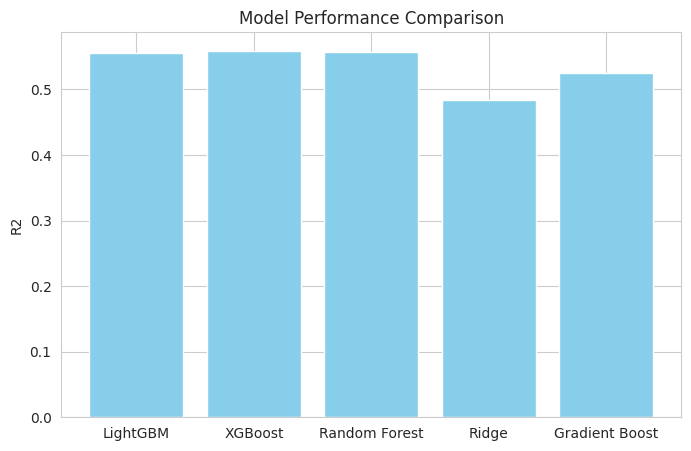

In [73]:
models = ["LightGBM", "XGBoost", "Random Forest", "Ridge", "Gradient Boost"]
rmses = [lgb_r2, xgb_r2, rf_r2, ridge_r2, gb_r2]

plt.figure(figsize=(8, 5))
plt.bar(models, rmses, color='skyblue')
plt.ylabel("R2")
plt.title("Model Performance Comparison")
plt.show()

- XGBoost and Random Forest are best-performing models.

- Gradient Boost and LightGBM also perform well and are close in accuracy.

- Ridge Regression performs the weakest in terms of variance explanation, which aligns with it being a simpler linear model.

- Tree-based models are better suited for this dataset, likely because:

  - There are nonlinear relationships.

  - Feature interactions matter.

  - The ensemble structure captures complexity better than linear models.

# HyperParameter Tuning

#### Tuning the 3 models using Time series split

In [74]:
tscv = TimeSeriesSplit(n_splits=3)

### 1. XGboost

In [75]:
xgb_param_dist = {
    'n_estimators': [100, 120, 150, 180, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.03, 0.05],
    'subsample': [0.7, 0.75, 0.8],
    'colsample_bytree': [0.7, 0.75, 0.8],
    'min_child_weight': [1, 3, 5]
}

In [76]:
xgb_grid = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=xgb_param_dist,
    n_iter=10, 
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

xgb_grid.fit(X_train_scaled, y_tr)
best_xgb_config = xgb_grid.best_params_
best_xgb_score = -xgb_grid.best_score_

print("Best XGBoost params: " , best_xgb_config)
print("Best XGBoost MAE: ", best_xgb_score)

Best XGBoost params:  {'subsample': 0.8, 'n_estimators': 120, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best XGBoost MAE:  14.264324127904457


### 2. Random Forest

In [77]:
rf_param_dist = {
    'n_estimators': [50, 60, 80, 100, 120],
    'max_depth': [5, 6, 7, 8, 10],
    'min_samples_split': [5, 6, 8, 10],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt', 'log2', 0.7, 0.8]
}

In [78]:
rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=10,  
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_grid.fit(X_train_scaled, y_tr)
best_rf_config = rf_grid.best_params_
best_rf_score = -rf_grid.best_score_

print('Best Random Forest params: ', best_rf_config)
print('Best Random Forest MAE: ',best_rf_score)

Best Random Forest params:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 10}
Best Random Forest MAE:  14.36504047485188


## Training final models with the best parameters

In [79]:
xgb_final = xgb.XGBRegressor(**best_xgb_config, random_state=42, n_jobs=-1)
xgb_final.fit(X_train_scaled, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [80]:
rf_final = RandomForestRegressor(**best_rf_config, random_state=42, n_jobs=-1)
rf_final.fit(X_train_scaled, y_tr)

RandomForestRegressor(max_depth=10, max_features=0.7, min_samples_leaf=4,
                      min_samples_split=5, n_jobs=-1, random_state=42)

In [81]:
xgb = xgb_final.predict(X_train_scaled)
rf = rf_final.predict(X_train_scaled)

In [82]:
rule_baseline = train_data["smoothed_rule_forecast"].values
r2_rule_only = r2_score(y_train_full, rule_baseline)
mae_rule_only = mean_absolute_error(y_train_full, rule_baseline)

In [83]:
xgb_full_pred = rule_baseline + xgb
r2_xgb = r2_score(y_train_full, xgb_full_pred)
mae_xgb = mean_absolute_error(y_train_full, xgb_full_pred)

In [84]:
rf_full_pred = rule_baseline + rf
r2_rf = r2_score(y_train_full, rf_full_pred)
mae_rf = mean_absolute_error(y_train_full, rf_full_pred)

# Ensemble Predictions

In [85]:
ml_avg = (xgb + rf ) / 2

In [86]:
final_predictions = 0.5 * rule_baseline + 0.5 * (rule_baseline + ml_avg)
r2_ensemble = r2_score(y_train_full, final_predictions)
mae_ensemble = mean_absolute_error(y_train_full, final_predictions)

In [87]:
print("Ensemble R²: ", r2_ensemble)

Ensemble R²:  0.5318145334495966


# Test Set Predictions

In [88]:
test_submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

In [89]:
test_submission[["book_theater_id", "show_date"]] = test_submission["ID"].str.rsplit("_", n=1, expand=True)
test_submission["show_date"] = pd.to_datetime(test_submission["show_date"])

In [90]:
test_submission["day_of_week"] = test_submission["show_date"].dt.dayofweek
test_submission["month_num"] = test_submission["show_date"].dt.month
test_submission["weekend_flag"] = test_submission["day_of_week"].isin([5, 6]).astype(int)

In [91]:
if "holiday_flg" in calendar_df.columns:
    holiday_lookup = calendar_df.set_index("show_date")["holiday_flg"]
    test_submission["holiday_flag"] = test_submission["show_date"].map(holiday_lookup).fillna(0)
else:
    test_submission["holiday_flag"] = 0

In [92]:
last_known = visits_df.groupby("book_theater_id").last()
for feat in ["audience_lag1", "audience_lag7", "audience_lag14", "rolling_mean_7d", 
             "rolling_mean_14d", "rolling_mean_30d", "ema_7d", "tickets_booked", 
             "diff_1d", "diff_7d", "theater_baseline"]:
    test_submission[feat] = test_submission["book_theater_id"].map(last_known[feat]).fillna(overall_avg)

In [93]:
test_submission["theater_frequency"] = test_submission["book_theater_id"].map(theater_freq).fillna(theater_freq.median())

In [94]:
test_submission[impute_columns] = median_imputer.transform(test_submission[impute_columns])

In [95]:
# Rule-based predictions
test_submission["rule_based_forecast"] = test_submission.apply(generate_rule_based_forecast, axis=1)
test_submission["rule_based_forecast"] = test_submission["rule_based_forecast"].rolling(3, min_periods=1).mean()

In [96]:
# Scale test features
X_test_data = test_submission[ml_features].copy()
X_test_scaled = X_test_data.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test_data[numerical_features])

In [97]:
xgb_test = xgb_final.predict(X_test_scaled)
rf_test = rf_final.predict(X_test_scaled)

In [98]:
ml_test_avg = (xgb_test + rf_test ) / 2
test_submission["audience_count"] = 0.5 * test_submission["rule_based_forecast"] + 0.5 * (test_submission["rule_based_forecast"] + ml_test_avg)

test_submission["audience_count"] = test_submission["audience_count"].clip(lower=0).round().astype(int)

In [99]:
test_submission[["ID", "audience_count"]].to_csv("submission.csv", index=False)

In [100]:
print("Mean prediction", test_submission['audience_count'].mean())
print("Std prediction: ", test_submission['audience_count'].std())
print("Min prediction: ", test_submission['audience_count'].min())
print("Max prediction: ", test_submission['audience_count'].max())

Mean prediction 40.91130261152856
Std prediction:  22.021647499880732
Min prediction:  1
Max prediction:  149


# Milestones

## Milestone1


In [101]:
# book_booking.shape

In [102]:
# book_theaters.head()

In [103]:
# book_theaters.isna().sum()

In [104]:
# booking['theater_area'].nunique()

In [105]:
# ans = cine_theaters.select_dtypes(include='object').shape[1]
# ans

In [106]:
# most_frequent = book_theaters['theater_type'].value_counts().idxmax()
# most_frequent

In [107]:
# cine_booking['cine_theater_id'].nunique()

In [108]:
# cinePOS.isna().sum()

In [109]:
# start_date = book_booking['show_datetime'].min()
# end_date = book_booking['show_datetime'].max()

# print(start_date)
# print(end_date)

In [110]:
# submission

In [111]:
# dates = pd.to_datetime(submission['ID'].str[-10:], errors='coerce')

# start_date = dates.min().strftime("%d-%m-%Y")
# end_date = dates.max().strftime("%d-%m-%Y")

# print(start_date)
# print(end_date)

## Milestone 2

In the booknow_booking.csv file, how many total booking records (rows) were made on the same calendar day as the show's date?

Note: The question refers to day / date and not datetime

In [112]:
# booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'], errors='coerce')
# booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'], errors='coerce')

# booknow_booking['booking_date'] = booknow_booking['booking_datetime'].dt.date
# booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.date

# same_day_bookings = booknow_booking[booknow_booking['booking_date'] == booknow_booking['show_date']]

# len(same_day_bookings)

In [113]:
# date_info

How many unique calendar months (e.g., Jan 2023, Feb 2023, ...) are present in the show_date column of the date_info.csv file? *

In [114]:
# date_info['show_date'] = pd.to_datetime(date_info['show_date'])

# date_info['year_month'] = date_info['show_date'].dt.to_period('M')

In [115]:
# date_info['year_month'].nunique()

What percentage of bookings in booknow_booking.csv were made on a Sunday? *

In [116]:
# booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'], errors='coerce')
# booknow_booking['day_of_week'] = booknow_booking['booking_datetime'].dt.day_name()

# sundays = (booknow_booking['day_of_week']=='Sunday').sum()
# total = len(booknow_booking)

# percen = (sundays/total)*100
# percen

In [117]:
# booknow_theaters

In the booknow_theaters.csv file, if you decided to impute any missing latitude values by the mean latitude of only theaters with theater_type equal to Drama, what would be the imputation value?

In [118]:
# theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")

In [119]:
# max = theaters['latitude'].max()
# min = theaters['latitude'].min()
# range = max-min
# range

What is the range (Maximum - Minimum) of the latitude column in the booknow_theaters.csv file (rounded to 4 decimal places)?

In [120]:
# theaters_drama = theaers[theaters['theater_type']=='Drama']

In [121]:
# theaters_drama['latitude'].mean()

To handle potential outliers in ticket sales, you decide to cap the tickets_sold column in cinePOS_booking.csv at the 95 th  percentile. Enter that value

In [122]:
# cine_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")

# cap = cine_booking['tickets_sold'].quantile(0.95)

# cap

Appy OneHot Encoding on all the categorical columns of the dataset cinePOS_theaters.csv. What is the shape of the dataset after applying this transformation?

Note: The result obtained highlights a potential drawback of OneHot encoding. Read about other forms of encoding and the advantages / disadvantages they offer.

In [123]:
# cine_theater = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")

# cat_cols = cine_theater.select_dtypes(include=['object']).columns.tolist()

# df = pd.get_dummies(cine_theater, columns=cat_cols)

# df.shape

## Milestone 3

In [124]:
import pandas as pd

For this milestone, only the booknow_visits.csv file is to be used. Using the show_date column, create new columns for day, month, year and dayofyear. Once the new columns are created, drop the show_date column

Split the data into X & y with the target variable audience_count as y and the remaining features as X. 

Split the dataset so that 20% of it is kept for validation. Ensure the split preserves the time series nature of the dataset. This data will be referred to as X_train, X_test and y_train, y_test

In [125]:
# booknow_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')

In [126]:
# booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])

In [127]:
# booknow_visits['day'] = booknow_visits['show_date'].dt.day

In [128]:
# booknow_visits['month'] = booknow_visits['show_date'].dt.month
# booknow_visits['year'] = booknow_visits['show_date'].dt.year

In [129]:
# booknow_visits['dayofyear'] = booknow_visits['show_date'].dt.dayofyear

In [130]:
# booknow_visits = booknow_visits.drop(columns='show_date')

In [131]:
# X, y = booknow_visits.drop(columns='audience_count'), booknow_visits['audience_count']

In [132]:
# from sklearn.model_selection import train_test_split

In [133]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [134]:
# X_train.shape

Use MinMaxScaler for the numerical columns & OneHotEncoding for the categorical columns. These transformations are to be applied on both the train & test datasets. Answer all the questions that follow.

In [135]:
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

In [136]:
# X_train.select_dtypes(include='number').columns

In [137]:
# X_train.select_dtypes(include='object').columns


In [138]:
# trf = ColumnTransformer([
#     ('ms', MinMaxScaler(), ['day', 'month', 'year', 'dayofyear']),
#     ('ohe', OneHotEncoder(sparse_output=False), ['book_theater_id'])
# ])

# X_train = trf.fit_transform(X_train)
# X_test = trf.transform(X_test)

Use LinearSVR for training and enter the r2_score obtained on the test dataset. Upto 3 decimal places

In [139]:
# from sklearn.svm import LinearSVR

In [140]:
# lsvr = LinearSVR()

# lsvr.fit(X_train, y_train)

In [141]:
# lsvr.score(X_test, y_test)

Use TruncatedSVD with n_components = 4 and train LinearSVR again. What is the mean absolute error obtained on the training data? Upto 3 decimal places *

In [142]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.svm import LinearSVR
# from sklearn.metrics import mean_absolute_error, r2_score

In [143]:
# svd = TruncatedSVD(n_components=4, random_state=42)
# X_train_svd = svd.fit_transform(X_train)
# X_test_svd = svd.transform(X_test)


In [144]:
# svr = LinearSVR(random_state=42)
# svr.fit(X_train_svd, y_train)

In [145]:
# y_pred_train = svr.predict(X_train_svd)

In [146]:
# mae = mean_absolute_error(y_train, y_pred_train)
# print(f"Mean Absolute Error: {mae:.3f}")

Based on the previous question, what is the r2_score obtained on the test data? Upto 3 decimal places *

In [147]:
# y_pred = svr.predict(X_test_svd)

In [148]:
# r2_score(y_test, y_pred)

Use SelectKBest with k = 2 , score_func = mutual_info_regression.  Based on attributes output by SelectKBest, what is the maximum score obtained? 

In [149]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [150]:
# selector = SelectKBest(score_func=mutual_info_regression, k=2)
# selector.fit(X_train, y_train)

In [151]:
# scores = selector.scores_
# max_score = scores.max()

# print(f"Maximum mutual information score: {max_score:.3f}")


## Milestone 4

For this milestone, only the booknow_visits.csv file is to be used. Using the show_date column, create new columns for day, month, year and dayofyear. Once the new columns are created, drop the show_date column

Split the data into X & y with the target variable audience_count as y and the remaining features as X. 

Split the dataset so that 20% of it is kept for validation. Ensure the split preserves the time series nature of the dataset. This data will be referred to as X_train, X_test and y_train, y_test

Use MinMaxScaler for the numerical columns & OneHotEncoding for the categorical columns. These transformations are to be applied on both the train & test datasets. Answer all the questions that follow.

In [152]:
# X, y = booknow_visits.drop(columns='audience_count'), booknow_visits['audience_count']

In [153]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [154]:
# trf = ColumnTransformer([
#     ('ms', MinMaxScaler(), ['day', 'month', 'year', 'dayofyear']),
#     ('ohe', OneHotEncoder(sparse_output=False), ['book_theater_id'])
# ])

# X_train = trf.fit_transform(X_train)
# X_test = trf.transform(X_test)

In [155]:
# from sklearn.tree import DecisionTreeRegressor 

In [156]:
# dt = DecisionTreeRegressor()

Train the DecisionTreeRegressor with default parameters on X_train. What is the r2_score obtained on X_train? (upto 3 decimal places)

In [157]:
# dt.fit(X_train, y_train)

In [158]:
# dt.score(X_train, y_train)

In [159]:
# y_pred = dt.predict(X_test)

Use the model trained in the previous question to predict for X_test. What is the r2_score obtained on X_test? (upto 3 decimal places)

In [160]:
# r2_score(y_test, y_pred)

Perform Hyper Paramter Tuning for the Decision Tree model. Set random state as 42 and use TimeSeriesSplit with n_splits = 5 for cross validation. 

Hyperparameter tuning is to be done over the following:
- max_depth as [None,3,5,10]
- min_samples_split as [2,5,10]
- min_samples_leaf as [1,2,4]

Paste the output obtained when printing the best_params_

In [161]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [162]:
# tscv = TimeSeriesSplit(n_splits=5)

# dt = DecisionTreeRegressor(random_state=42)

# param_grid = {
#     'max_depth': [None, 3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(
#     estimator=dt,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='neg_mean_absolute_error',  
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)

In [163]:
# grid.best_params_

## Milestone 5

In [164]:
# import pandas as pd

In [165]:
# booknow_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')

In [166]:
# booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])

In [167]:
# booknow_booking['show_date'] = booknow_booking['show_datetime'].dt.date

In [168]:
# booknow_booking

Load the file booknow_booking.csv. Extract the date part from show_datetime as a new column show_date.
Group the data by book_theater_id and show_date, and calculate the total number of tickets booked per theater per day.

What is the shape of the resulting dataset (number of rows, columns)?

In [169]:
# grouped_booking = booknow_booking.groupby(["book_theater_id", "show_date"])["tickets_booked"].sum().reset_index()
# grouped_booking.shape

In [170]:
# grouped_booking

Load the file cinePOS_booking.csv. Extract show_date from show_datetime.
Group the data by cine_theater_id and show_date, summing the total tickets_sold.

After aggregation, what is the shape of the resulting dataset?

In [171]:
# cinePOS_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')

In [172]:
# cinePOS_booking['show_datetime'] = pd.to_datetime(cinePOS_booking['show_datetime'])

In [173]:
# cinePOS_booking['show_date'] = cinePOS_booking['show_datetime'].dt.date

In [174]:
# grouped_cine = cinePOS_booking.groupby(["cine_theater_id", "show_date"])["tickets_sold"].sum().reset_index()
# grouped_cine.shape

Merge the BookNow and CinePOS aggregated datasets (from previous questions) on book_theater_id and show_date using an outer join, with the help of movie_theater_id_relation.csv.

In [175]:
# relation = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')

In [176]:
# cine_agg = grouped_cine.merge(relation, on = 'cine_theater_id', how='outer')

In [177]:
# cine_agg

In [178]:
# final = cine_agg.merge(grouped_booking, on = ['book_theater_id', 'show_date'], how='outer')

In [179]:
# final.shape

In [180]:
# final

Merge the combined booking dataset with the BookNow visits file (booknow_visits.csv), which contains the target column audience_count.
Create a new feature that stores the previous day’s audience count for each theater.

After creating the one-day lag feature, how many missing values are introduced in this new column?

In [181]:
# booknow_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')

In [182]:
# final_df = final.merge(booknow_visits, on = ['book_theater_id'], how='left')

In [183]:
# final_df

In [184]:
# final_df["show_date_y"] = pd.to_datetime(final_df["show_date_y"])

# final_df = final_df.sort_values(["book_theater_id", "show_date_y"])

# final_df["prev_day_audience_count"] = (
#     final_df.groupby("book_theater_id")["audience_count"].shift(1)
# )

# missing_count = final_df["prev_day_audience_count"].isna().sum()

# print("Number of missing values in prev_day_audience_count:", missing_count)

Select the theater ID 'book_00001' and perform the Augmented Dickey-Fuller (ADF) test.
What is the p-value?

In [185]:
# import pandas as pd
# from statsmodels.tsa.stattools import adfuller

In [186]:
# final_df["show_date"] = pd.to_datetime(final_df["show_date_y"])

In [187]:
# theater_data = final_df[final_df["book_theater_id"] == "book_00001"]

In [188]:
# final_df['book_theater_id'].unique()

In [189]:
# theater_data = theater_data.sort_values("show_date")

In [190]:
# ts = theater_data["audience_count"].dropna()

In [191]:
# len(theater_data)

In [192]:
# from statsmodels.tsa.arima.model import ARIMA

In [193]:
# theater_id = "book_00001"
# theater_data = final_df[final_df["book_theater_id"] == theater_id].copy()

In [194]:
# theater_data = theater_data.sort_values("show_date")[["show_date", "audience_count"]]
# theater_data = theater_data.dropna()

In [195]:
# print("Total records:", len(theater_data))